In [53]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# file_name = "../Aircraft_01.h5"

# # store = pd.HDFStore(file_name)
# # store_keys = store.keys()
# # with pd.HDFStore(f'{file_name[:-3]}_dask.h5', mode = "w") as h :
# #     for i in range(len(store)) :
# #         key = store_keys[i]
# #         h.put(key, store[store_keys[i]], format = 'table')
# ddf = dd.read_hdf(f'{file_name[:-3]}_dask.h5', '*')

$N_2 = c + \alpha N_1 + \beta T_1 + \gamma Alt + \theta M + \epsilon$

$X := \begin{pmatrix} 
1 & N_1^{1} & T_1^{1} & Alt^{1} & M^1 \\ 
\vdots  & \vdots &\vdots &\vdots & \vdots \\
1 & N_1^{N} & T_1^{N} & Alt^{N} & M^N \\ 
\end{pmatrix}$ et $a = \begin{pmatrix} c \\ \alpha \\ \beta \\ \gamma \\ \theta
\end{pmatrix}$

On a $N_2 = X a + \epsilon$ 

$\hat{a} = (X^T X)^{-1} X^T Y$

$N_2  = a_0 + a_1 N_1 + a_2 T_1 + a_3 Alt + a_4 M + \epsilon$

$X := (1 | N_1 | T_1 | Alt | M )$

On a $\^a = (X^T X)^{-1} X^T N_2$

Ici on voit qu'il y a une différence entre les deux graphiques, maintenant on va essaye avec une distribution sur les poids $a$.

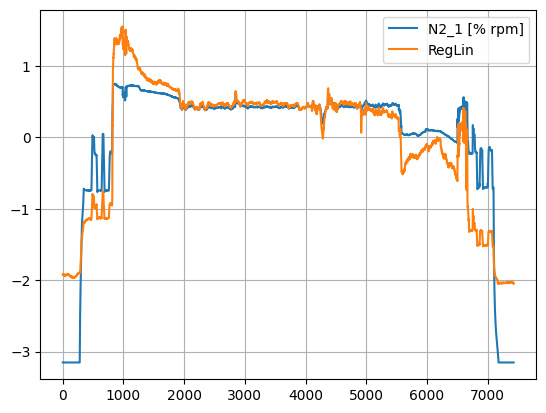

In [55]:
variableNames = ["N1_1 [% rpm]", "T1_1 [deg C]", "ALT [ft]", "M [Mach]"]
# X = ddf.partitions[0][variableNames].compute().values
f = open("../data_prepare/variables.npy", "rb")
X = np.load(f)
f.close()
Xnorm = (X - X.mean(axis=0)) / X.std(axis=0)
Xhat = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), Xnorm), axis=1)

targetName = ["N2_1 [% rpm]"]
# y = ddf.partitions[0][targetName].compute().values.reshape(-1, 1)
f = open("../data_prepare/target.npy", "rb")
y = np.load(f)
f.close()

yNorm = (y - y.mean(axis=0)) / y.std(axis=0)

aHat = np.linalg.solve(np.matmul(Xhat.transpose(), Xhat),
                       np.matmul(Xhat.transpose(), yNorm))
yHat = np.matmul(Xhat, aHat)


plt.figure()
plt.plot(yNorm, label=targetName[0])
plt.plot(yHat, label="RegLin")
plt.legend()
plt.grid("on")
plt.show()


In [56]:
tX = torch.Tensor(Xnorm)
ty = torch.Tensor(yNorm)
tyHat = torch.Tensor(yHat)

print("tX.shape : ", tX.shape)
print("ty.shape : ", ty.shape)
print("tyHat.shape :", tyHat.shape)

tX.shape :  torch.Size([7429, 4])
ty.shape :  torch.Size([7429, 1])
tyHat.shape : torch.Size([7429, 1])


In [57]:
def modelSize(ns):
    """ calcul le nombre de poids

    Parameters
    ----------
    ns : list
        liste des nombres de neurones par couches
    Returns
    -------
    int
        Le nombre de poids
    """
    return np.sum([(ns[i]+1)*ns[i+1] for i in range(len(ns)-1)])

In [58]:
class resLin(nn.Module) :
    def __init__(self, nin, nout) :
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.Layer1 = nn.Linear(nin,nout)
        
    def forward(self, tX) :
        x = self.Layer1(tX)
        return x
    
    def zero_grad(self, set_to_none: bool = False) -> None:
        return super().zero_grad(set_to_none)
    
    def set_params(self, param_list):
        for p1, p2 in zip(list(self.parameters()), param_list) :
            p1.data = p2
        return self

In [59]:
# nbFeatures = 4
# nbTarget = 1
# Lin = nn.Linear(nbFeatures, nbTarget)

# tXhat = torch.Tensor(Xhat[:,1:])
# tyNorm =torch.Tensor(yNorm)
# tyHat = torch.Tensor(yHat)

# plt.figure()
# plt.plot(tyNorm, label = targetName[0], color = 'k', linestyle = 'dashed')
# plt.plot(tyHat, label = "RegLin", color = 'red', linestyle = 'dashed')
# plt.plot(Lin(tXhat).detach().numpy(), label = "un exemple de courbe", color = 'orange', linestyle = 'dashed')
# plt.legend()
# plt.grid("on")
# plt.show()

In [60]:
nin = 4
nout = 1
myModel = resLin(nin, nout)

In [61]:
modelParamShapes = [p.data.shape for p in list(myModel.parameters())]

In [62]:
# Hypperparamètres
N = 2000
lmax = 6
P0 = 0.1
epsilon = 0.01
fact = 0.8
sigma_0 = (lmax + 1) * fact
ns = [4,1]
activation = "relu"

# Temperature initiale
Temp = 0.05

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

In [63]:
nw = modelSize(ns)

# distribution a priori
priorDist = torch.distributions.Normal(0, sigma_0)

In [64]:
thetas = [([torch.randn(shape) * sigma_0 for shape in modelParamShapes])
          for n in range(N)]

tYs = torch.concatenate(
    tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(tYs.t(), ty.t(), p=pdist) ** 2) / nw

#
rhoMin = []
rhoMax = []
epsJ = []
#
NP0 = int(N*P0)
invP0 = int(1/P0)
j = 0

# reglage de temperature
t = 0
TempCur = Temp
while (rhos[0, 0] > epsilon):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = [thetas[i] for i in list(indices[:, 0])]

    epsilon_j = rhos[NP0]
    epsJ.append(str(np.float32(epsilon_j[0].detach())))

    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:NP0]
    rhoSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - fact * lmax

    #
    thetas = thetasSeeds
    rhos = rhos[:NP0]

    for g in range(invP0 - 1):
        # resampling
        thetasResamples = [[(p + torch.randn(p.shape)*sigma_j)
                            for p in theta] for theta in thetasSeeds]
        # evaluation
        logPriorResamples = [
            [priorDist.log_prob(p) for p in theta] for theta in thetasResamples]
        logPriorSeeds = [
            [priorDist.log_prob(p) for p in theta] for theta in thetasSeeds]

        rj = [[torch.exp(- (p1 - p2)) for (p1, p2) in zip(l1, l2)]
              for (l1, l2) in zip(logPriorResamples, logPriorSeeds)]

        sj = [[(torch.minimum(t, torch.ones(t.shape)))
               for t in theta] for theta in rj]

        bj = [[(torch.rand(t.shape) <= t).float()
               for t in theta] for theta in sj]

        thetasNow = [[(bLoc * tRsLoc + (1 - bLoc) * tSLoc) for (tSLoc, tRsLoc, bLoc)
                      in zip(tS, tRs, b)] for (tS, tRs, b) in zip(thetasSeeds, thetasResamples, bj)]

        tYsNow = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetasNow]), 1)
        rhoNow = (torch.cdist(tYsNow.t(), ty.t(), p=pdist) ** 2) / nw

        thetasVal = [(tNow) if (rhoN <= epsilon_j) else (tSeed)
                     for (tSeed, tNow, rhoN) in zip(thetasSeeds, thetasNow, rhoNow)]
        rhoVal = (rhoNow <= epsilon_j) * (rhoNow - rhoSeeds) + rhoSeeds

        # Mise à jour
        thetasSeeds = thetasVal
        thetas += thetasSeeds
        rhoSeeds = rhoVal
        rhos = torch.concatenate((rhos, rhoSeeds))

        # Réglage de la température
        TempCur = Temp / np.log(2 + t)
        t += 1

    j += 1
    if (j >= lmax):
        break

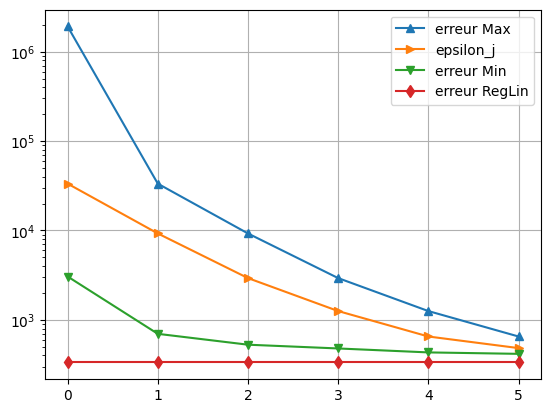

In [65]:
rhoFloor = torch.ones(lmax) *  (torch.cdist(ty.t(), tyHat.t(), p=pdist) ** 2) / nw
plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(rhoFloor.t(), label = 'erreur RegLin', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [66]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)

In [67]:
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

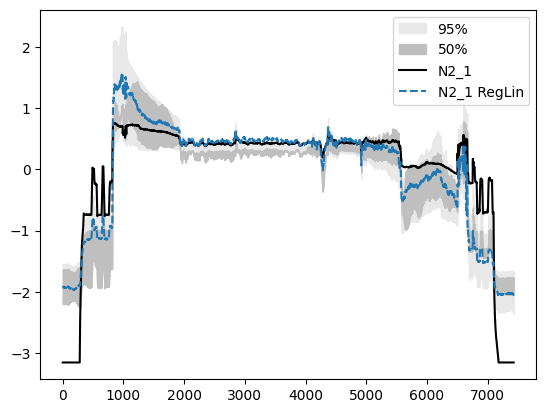

In [68]:
plt.clf()


plt.fill_between(np.arange(ty.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(ty.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

# plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(ty, label='N2_1', color = 'k')

plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()


In [69]:
idxList = 0
for theta in thetas : 
    idxParam = 0
    for p in theta :
        f = open("../data_prepare/rotParams/{}_{}_lin.pt".format(idxList, idxParam), "wb")
        torch.save(p, f)
        f.close()
        idxParam += 1
    idxList += 1

Maintenant on va utiliser un réseau de neurones à avec 4-2-1

In [70]:
class resNet(nn.Module) :
    def __init__(self, nin, nout) :
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.Layer1 = nn.Linear(nin,2)
        self.Layer2 = nn.Linear(2, nout)

    def forward(self, tX) :
        x = self.Layer1(tX)
        x = torch.relu(x)
        x = self.Layer2(x)
        return x
    
    def zero_grad(self, set_to_none: bool = False) -> None:
        return super().zero_grad(set_to_none)
    
    def set_params(self, param_list):
        for p1, p2 in zip(list(self.parameters()), param_list) :
            p1.data = p2
        return self

In [71]:
nin = 4
nout = 1
myModel = resNet(nin, nout)

In [72]:
modelParamShapes = [p.data.shape for p in list(myModel.parameters())]

In [73]:
# Hypperparamètres
N = 5000
lmax = 6
P0 = 0.1
epsilon = 0.01
fact = 0.5
sigma_0 = (lmax + 1) * fact
ns = [4,2,1]
# Temperature initiale
Temp = 1

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

In [74]:
nw = modelSize(ns)

# distribution a priori
priorDist = torch.distributions.Normal(0, sigma_0)

In [75]:
thetas = [([torch.randn(shape) * sigma_0 for shape in modelParamShapes])
          for n in range(N)]

tYs = torch.concatenate(
    tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(tYs.t(), ty.t(), p=pdist) ** 2) / nw

#
rhoMin = []
rhoMax = []
epsJ = []
#
NP0 = int(N*P0)
invP0 = int(1/P0)
j = 0

# reglage de temperature
t = 0
TempCur = Temp
while (rhos[0, 0] > epsilon):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = [thetas[i] for i in list(indices[:, 0])]

    epsilon_j = rhos[NP0]
    epsJ.append(str(np.float32(epsilon_j[0].detach())))

    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:NP0]
    rhoSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - fact * lmax

    #
    thetas = thetasSeeds
    rhos = rhos[:NP0]

    for g in range(invP0 - 1):
        # resampling
        thetasResamples = [[(p + torch.randn(p.shape)*sigma_j)
                            for p in theta] for theta in thetasSeeds]
        # evaluation
        logPriorResamples = [
            [priorDist.log_prob(p) for p in theta] for theta in thetasResamples]
        logPriorSeeds = [
            [priorDist.log_prob(p) for p in theta] for theta in thetasSeeds]

        rj = [[torch.exp(- (p1 - p2)) for (p1, p2) in zip(l1, l2)]
              for (l1, l2) in zip(logPriorResamples, logPriorSeeds)]

        sj = [[(torch.minimum(t, torch.ones(t.shape)))
               for t in theta] for theta in rj]

        bj = [[(torch.rand(t.shape) <= t).float()
               for t in theta] for theta in sj]

        thetasNow = [[(bLoc * tRsLoc + (1 - bLoc) * tSLoc) for (tSLoc, tRsLoc, bLoc)
                      in zip(tS, tRs, b)] for (tS, tRs, b) in zip(thetasSeeds, thetasResamples, bj)]

        tYsNow = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetasNow]), 1)
        rhoNow = (torch.cdist(tYsNow.t(), ty.t(), p=pdist) ** 2) / nw

        thetasVal = [(tNow) if (rhoN <= epsilon_j) else (tSeed)
                     for (tSeed, tNow, rhoN) in zip(thetasSeeds, thetasNow, rhoNow)]
        rhoVal = (rhoNow <= epsilon_j) * (rhoNow - rhoSeeds) + rhoSeeds

        # Mise à jour
        thetasSeeds = thetasVal
        thetas += thetasSeeds
        rhoSeeds = rhoVal
        rhos = torch.concatenate((rhos, rhoSeeds))

        # Réglage de la température
        TempCur = Temp / np.log(2 + t)
        t += 1

    j += 1
    if (j >= lmax):
        break

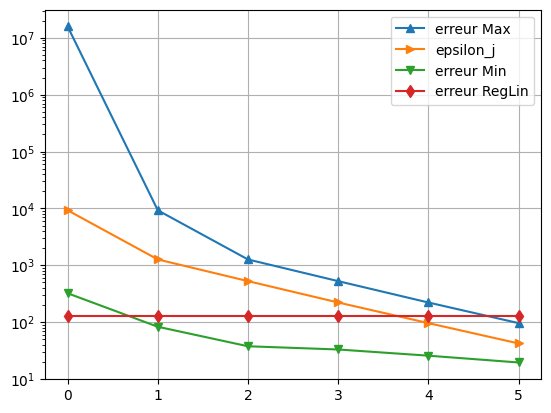

In [76]:
rhoFloor = torch.ones(lmax) *  (torch.cdist(ty.t(), tyHat.t(), p=pdist) ** 2) / nw

plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(rhoFloor.t(), label = 'erreur RegLin', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [77]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)

In [78]:
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

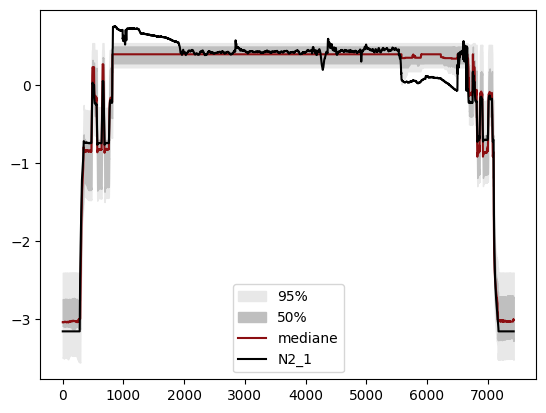

In [79]:
plt.clf()
plt.fill_between(np.arange(ty.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(ty.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(ty, label='N2_1', color = 'k')

# plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()

In [80]:
idxList = 0
for theta in thetas : 
    idxParam = 0
    for p in theta :
        f = open("../data_prepare/rotParams/{}_{}_net.pt".format(idxList, idxParam), "wb")
        torch.save(p, f)
        f.close()
        idxParam += 1
    idxList += 1